# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

Writing chap03-1.pdf
Writing chap03-1.png


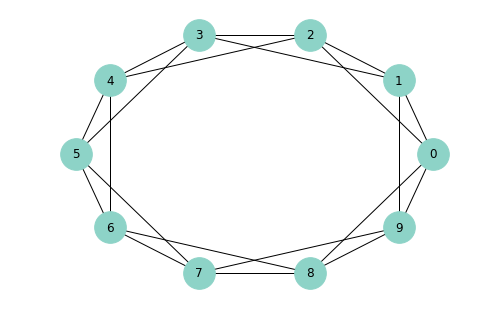

In [7]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)

thinkplot.save('chap03-1', clf=False)

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [9]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

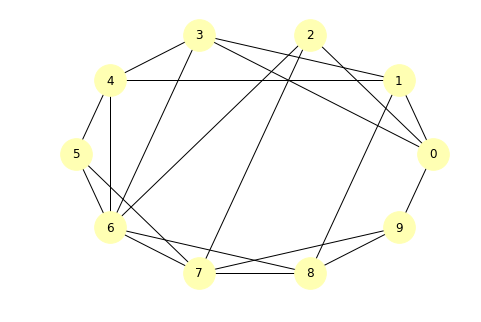

In [10]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [11]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

Writing chap03-2.pdf
Writing chap03-2.png


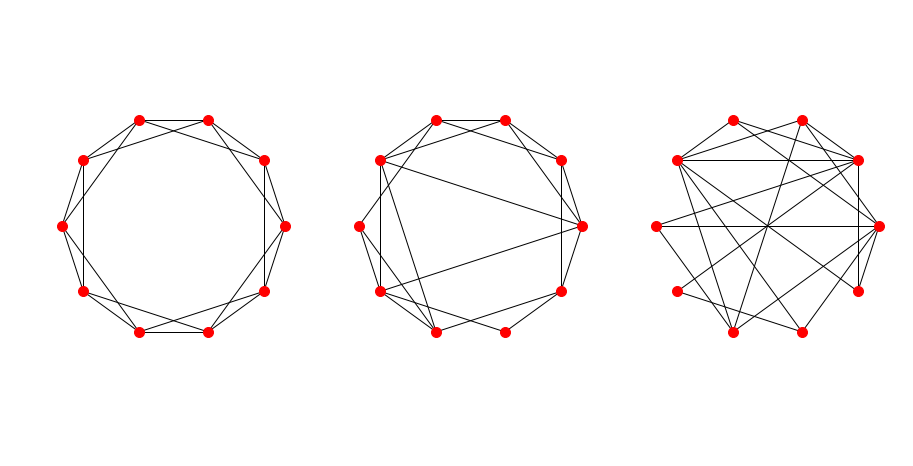

In [12]:
n = 10
k = 4
ns = 100

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.tight_layout()
thinkplot.save('chap03-2', clf=False)

**Exercise:** What is the order of growth of `rewire`?

In [13]:
# Solution goes here
"""The only costly operation in this function is the traversal of edges, making it O(m)."""

'The only costly operation in this function is the traversal of edges, making it O(m).'

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [14]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [15]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [16]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [17]:
clustering_coefficient(lattice)

0.5

Correct.

In [18]:
%timeit clustering_coefficient(lattice)

76.6 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [19]:
# Solution goes here

def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    edges = [G.has_edge(v, w) for v, w in all_pairs(neighbors)]
    return np.nanmean(edges)

In [24]:
%timeit clustering_coefficient(lattice)

183 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [20]:
# Solution goes here

"""clustering_coefficient calls node clustering (O(k^2)) once for every node. So the overall
runtime is O(nk^2)."""

'clustering_coefficient calls node clustering (O(k^2)) once for every node. So the overall\nruntime is O(nk^2).'

## Path length

The following function computes path lengths between all pairs of nodes

In [21]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist

The characteristic path length is the mean path length for all pairs.

In [22]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [23]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

0.90000000000000002

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [24]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.399999999999999

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [25]:
# Solution goes here

lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.5

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [26]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [32]:
%time run_one_graph(1000, 10, 0.01)

8.162078 0.642895959596
CPU times: user 3.63 s, sys: 0 ns, total: 3.63 s
Wall time: 3.64 s


(8.1620779999999993, 0.64289595959595958)

Now we'll run it with a range of values for `p`.

In [27]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [28]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

Here are the raw results.  Warning: this takes a few minutes to run.

In [37]:
%time res = run_experiment(ps)

0.0001
40.57323 0.666206565657
50.4 0.666666666667
50.4 0.666666666667
42.339582 0.666206565657
50.4 0.666666666667
47.164194 0.666423232323
50.4 0.666666666667
49.967736 0.666134343434
40.016814 0.666278787879
50.4 0.666666666667
50.4 0.666666666667
50.4 0.666666666667
50.4 0.666666666667
39.767096 0.665674242424
37.91298 0.665963131313
50.208114 0.666134343434
50.4 0.666666666667
39.697288 0.666351010101
50.4 0.666666666667
50.4 0.666666666667
0.000316227766017
38.463862 0.666351010101
32.58725 0.665425252525
37.205762 0.665890909091
26.609504 0.665358585859
36.489624 0.666035353535
34.631614 0.665602020202
41.650582 0.666278787879
45.419386 0.66617979798
33.514678 0.666107575758
38.557846 0.666278787879
32.04731 0.665148484848
33.337198 0.665602020202
38.758942 0.666278787879
45.688598 0.666278787879
43.300572 0.665746464646
36.273246 0.665286363636
43.594396 0.666351010101
37.798952 0.666035353535
45.726948 0.666351010101
46.307492 0.666351010101
0.001
27.552388 0.664582828283
24.7

Now we have to get the results into a form we can plot.

In [35]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
print(L)
print(C)

NameError: name 'res' is not defined

And normalize them so they both start at 1.0

In [29]:
L = np.array(L) / L[0]
C = np.array(C) / C[0]

NameError: name 'L' is not defined

Here's the plot that replicates Watts and Strogatz's Figure 2.

Writing chap03-3.pdf
Writing chap03-3.png


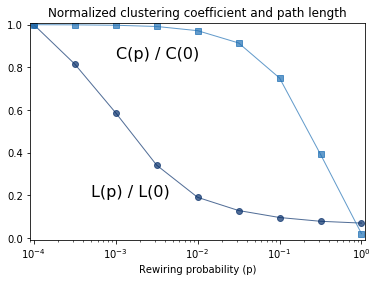

In [43]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='Rewiring probability (p)', xscale='log',
                 title='Normalized clustering coefficient and path length',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

thinkplot.save('chap03-3', clf=False)

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [30]:
lattice = make_ring_lattice(10, 4)

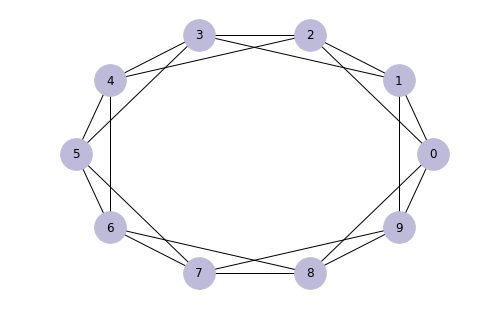

In [31]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [32]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [33]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [34]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [35]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [101]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [37]:
lattice = make_ring_lattice(10, 4)

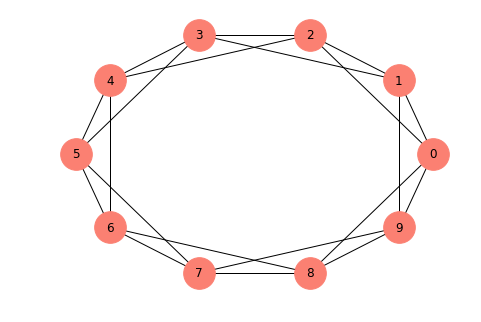

In [38]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [39]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [40]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [41]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [42]:
# Solution goes here
"""Nodes 496 - 501 inclusive"""


lattice = make_ring_lattice(1000, 10)
d3 = shortest_path_dijkstra(lattice, 0)

max_value = max(d3.values())
max_pairs = [(key, value) for (key, value) in d3.items() if value == max_value]

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [43]:
# Solution goes here

def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

In [44]:
# Solution goes here

def opposite_edges(nodes):
    ln = len(nodes)
    for i, n in enumerate(nodes):
        j = i + ln//2
        v = nodes[j % ln]
        yield n, v

In [45]:
# Solution goes here

def make_regular_graph(n, k):
    a = k // 2
    b = k % 2
    
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, a))
    
    if b != 0:
        if n % 2 != 0:
            raise ValueError('Both n and k cannot be odd')
        G.add_edges_from(opposite_edges(nodes))
    return G

AtlasView({1: {}, 13: {}})

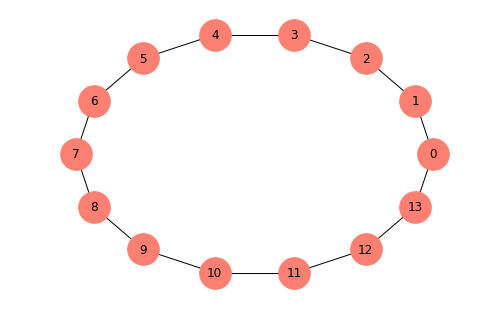

In [78]:
# Solution goes here

regular = make_regular_graph(14, 2)
nx.draw_circular(regular, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [88]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [89]:
# Solution goes here

%timeit reachable_nodes_bfs(lattice, 0)

2.09 ms ± 78.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [91]:
# Solution goes here

%timeit plain_bfs(lattice, 0)

1.42 ms ± 77.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [97]:
# Solution goes here

def plain_shortest_path(G, start):
    """A fast BFS node generator"""
    nextlevel = {start}
    dist = {}
    new_dist = 0
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in dist:
                dist[v] = new_dist
                nextlevel.update(G[v])
        new_dist += 1
    return dist

In [98]:
# Solution goes here

shortest_path_dijkstra(lattice, 0) == plain_shortest_path(lattice, 0)

True

In [99]:
# Solution goes here

%timeit shortest_path_dijkstra(lattice, 0)

1.78 ms ± 4.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
# Solution goes here

%timeit plain_shortest_path(lattice, 0)

1.37 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
# Solution goes here

In [60]:
# Solution goes here

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [61]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

In [62]:
# Solution goes here

"""Using pop(0) works in O(n) time, and don't need to check if c is not in queue. In a
completly connected graph O(n^3) is the runtime."""

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [113]:
# Solution goes here

def shortest_path_dijkstra_wrong(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

lattice = make_ring_lattice(10, 4)
a = shortest_path_dijkstra_wrong(lattice, 0)
b = shortest_path_dijkstra(lattice, 0)
print("dfs (wrong):", a)
print("bfs (correct):", b)

dfs (wrong): {0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 7: 2, 5: 3, 6: 3, 4: 4, 3: 5}
bfs (correct): {0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}


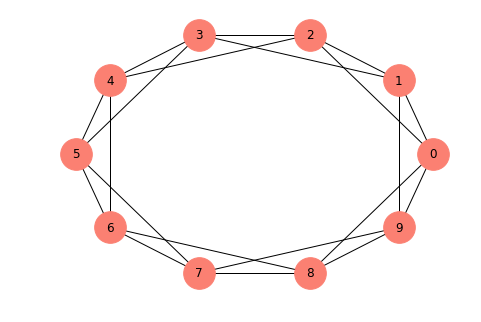

In [111]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)